In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from munch import Munch
from scipy.linalg import eigvalsh

from QO.general import vec2
from QO.hamiltonians import eigs_over_k

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)

from QO.thermodynamics import GCP_contributions, GCP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The point of this one is to try 

In [10]:
def k_space_H(t, k, L, U = 0, **kwargs):
    """
         | -2 t_y cos(k_y - l*phi), -t_x, ...     exp(-ik_xL) |
         | -t_x, .                                            |
     H = | 0   ,                                              |
         | .                                                  |
         | exp(ik_xL)  .....                                  |


    """
    phi = 2*np.pi / L.x

    #the factor of two along the diagonal comes from  adding the upper and lower triangle together
    upper_triangle = np.diag(U/2 - t.y * np.cos(k.y - np.arange(L.x)*phi), k = 0) \
        - t.x *   np.diag(np.ones(L.x-1), k =  1) \
        + np.exp(-1j * k.x * L.x) * np.diag([1,], k = L.x-1) \
    
    #make hermitian
    H = upper_triangle + upper_triangle.conj().T
    
    return H


def two_band_case(A, B, coupling_gamma = 0):
    """
    Construct a block hamiltonian from two NxN blocks corresponding to subsystems A and B

    H = |A Y|
        |Y B|

    """
    N = A.shape[0]
    Y = coupling_gamma * np.identity(N)
    return np.block([[A, Y],
                     [Y, B]])

In [11]:
offset = 0
coupling = 0.5

print(f"""
coupling = {coupling}
offset = {offset}
""")

def H_function(t, k, L):
    return two_band_case(k_space_H(t, k, L), k_space_H(t, k, L, U = offset), coupling_gamma = coupling) \
        + np.diag(np.random.normal(loc = 0, scale = 0.00001, size = 2*L.x))


coupling = 0.5
offset = 0




min_phi, max_phi = (0.006283185307179587, 0.3141592653589793)
min_L_x, max_L_x = (3.0, 160.0)


Doing a sweep over L_x producing a sweep over B

.............................................................................................................................................................took 48.309757232666016 seconds
(50, 156) (50,) (50, 79) (79,)
(50, 156) (50,) (50, 79) (79,)
(50, 156) (50,) (50, 79) (79,)

min_phi, max_phi = (0.006283185307179587, 0.3141592653589793)
min_L_x, max_L_x = (3.0, 160.0)
N = 157

coupling = 0.5
offset = 0



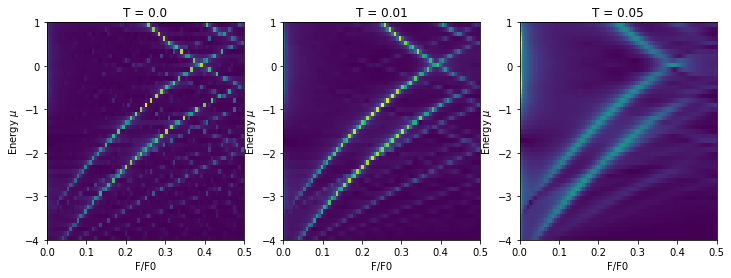

In [13]:
from itertools import count
from time import time
from numpy.linalg import eigvalsh


min_phi, max_phi = np.pi / 500, np.pi / 10
min_L_x, max_L_x = max(1,np.floor(1 / max_phi)), np.ceil(1 / min_phi)

print(f"""
min_phi, max_phi = {min_phi, max_phi}
min_L_x, max_L_x = {min_L_x, max_L_x}
""")
L_x = np.arange(min_L_x, max_L_x, dtype = int)

print(f"""
Doing a sweep over L_x producing a sweep over B
""")

params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(5,5),
)  

bins = np.linspace(-5,5,200)
Mus = np.linspace(-4,1,50)
Ts = np.array([0,0.01,0.05])
mu = -1

B = np.pi / L_x
dB = np.diff(B)
N = len(B)

GCPs = np.zeros([len(Mus), len(L_x), len(Ts)])

t = time()
for i, lx in enumerate(L_x):
    print('.', end = '')
    eigs = eigs_over_k(H_function, L = vec2(lx, 1), **params)
    
    for j, mu in enumerate(Mus):
        for k, T in enumerate(Ts):
            GCPs[j, i, k] = GCP(eigs, mu, T)
print(f"took {time() - t} seconds")


f, axes = plt.subplots(ncols = len(Ts), figsize = (12,4))
   
for k, T, ax in zip(count(), Ts, axes):
    dGCP = np.diff(GCPs[:, :, k], axis = -1)
    
    M = - dGCP / dB

    
    freqs = np.fft.rfftfreq(M.shape[-1])
    ffts = np.fft.rfft(M, axis = -1)
    print(M.shape, Mus.shape, ffts.shape, freqs.shape)

    ax.pcolormesh(freqs, Mus, np.abs(ffts))

    ax.set(ylabel = "Energy $\mu$", xlabel = "F/F0")
    ax.set(title = f'T = {T}')
    
print(f"""
min_phi, max_phi = {min_phi, max_phi}
min_L_x, max_L_x = {min_L_x, max_L_x}
N = {N}

coupling = {coupling}
offset = {offset}
""")


min_phi, max_phi = (0.006283185307179587, 0.3141592653589793)
min_L_x, max_L_x = (3.0, 160.0)
N = 157

coupling = 0.5
offset = -0.5



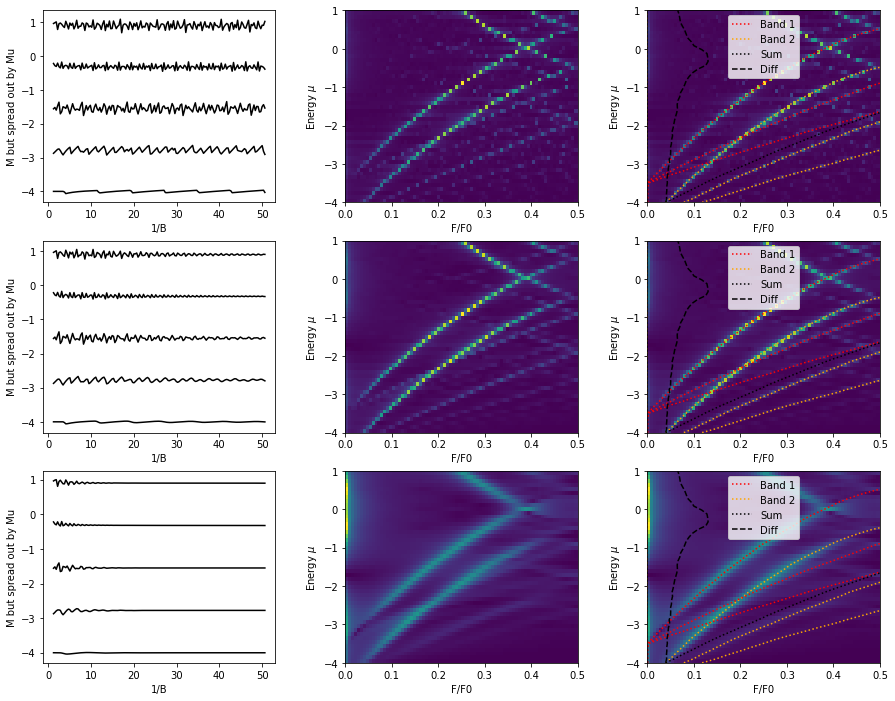

In [15]:
def lattice_dispersion(kx, ky, t = vec2(1,1)): return - 2 * t.x * np.cos(kx) - 2 * t.y * np.cos(ky) 

def FS_area(dispersion, N, E):
    kx = np.linspace(-np.pi, np.pi, N.x)[:, None]
    ky = np.linspace(-np.pi, np.pi, N.y)[None, :]
    sampled_dispersion = dispersion(kx, ky)
    
    dE = E[1] - E[0]
    number_of_states_less_than_E = np.array([np.sum(e > sampled_dispersion) for e in E])
    areas = number_of_states_less_than_E / (N.x * N.y)
    
    return areas

f, axes = plt.subplots(ncols = 3, nrows = len(Ts), figsize = (15,4*len(Ts)), gridspec_kw = dict(wspace = 0.3))

N = len(B)

for k, T, axes in zip(count(), Ts, axes):
    dGCP = np.diff(GCPs[:, :, k], axis = -1)
    M = - dGCP / dB
    
    freqs = np.fft.rfftfreq(M.shape[-1])
    ffts = np.fft.rfft(M, axis = -1)

    for j in range(0, len(Mus), 12):
        mu = Mus[j]
        axes[0].plot(B[1:]**-1, M[j] + mu, label = f"$\mu$ = {mu}", color = 'k')
    
    axes[1].pcolormesh(freqs, Mus, np.abs(ffts))
    axes[2].pcolormesh(freqs, Mus, np.abs(ffts))

    harmonics = 4
    pred = [_,_]
    for m in range(harmonics):
        for i, offset, color in zip([0,1], [+coupling, -coupling], ["r", "orange"]):
            pred[i], = axes[2].plot(m*FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = color,
                             linestyle = "dotted")

    s, = axes[2].plot(FS_area(lattice_dispersion, vec2(100,100), Mus) +
                        FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = 'k',
                         linestyle = "dotted")

    d, = axes[2].plot(-FS_area(lattice_dispersion, vec2(100,100), Mus) +
                            FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = 'k',
                             linestyle = "--")

    axes[0].set(ylabel = "M but spread out by Mu", xlabel = "1/B")
    axes[1].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))
    axes[2].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))

    
    axes[2].legend([pred[0], pred[1], s, d], ["Band 1", "Band 2", "Sum", "Diff"])

print(f"""
min_phi, max_phi = {min_phi, max_phi}
min_L_x, max_L_x = {min_L_x, max_L_x}
N = {N}

coupling = {coupling}
offset = {offset}
""")
f.savefig("two_band.png")